## Data Preparation

### Getting data from Alpha Vantage

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use("dark_background")

import numpy as np
import os
import json

from alpha_vantage.timeseries import TimeSeries


config = {
    "alpha_vantage": {
        "key": "6IN7ZPN5592V62VK", # API key
        "symbol": "IBM",
        "outputsize": "full", # full 20+ years
        "key_adjusted_close": "4. close", # adjusted close price for splits/dividends
    },
        "data": {
            "window_size": 20, # use information from past 20 days to predict
            "train_split_size": 0.70,
            "val_split_size": 0.15,
            "test_split_size": 0.15,
        }, 
        "plots": {
            "xticks_interval": 90, # show a date every 90 days
            "color_actual": "#ff8000",
            "color_train": "#58F6AF",
            "color_val": "#7CC2FF",
            "color_test": "#FF8484",
            "color_pred_train": "#3D9970",
            "color_pred_val": "#00529A",
            "color_pred_test": "#FF4136",
        },
        "model": {
            "input_size": 1, # we are only using 1 feature: close price
            "num_lstm_layers": 2,
            "lstm_size": 32, # hidden state dimensionality
            "dropout": 0.2,
        },
        "training": {
            "device": "cuda" if torch.cuda.is_available() else "cpu",
            "batch_size": 64,
            "num_epoch": 100,
            "learning_rate": 1e-2,
            "weight_decay": 1e-2,
            "scheduler_step_size": 40,
    }
}

In [110]:
json_file = f"stock_data_{config["alpha_vantage"]["symbol"]}.json"

def get_data_write_to_json(config):

    data_dict = {}
    
    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily(symbol=config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"]) # type: ignore

    data_dates = [date for date in data.keys()] # type: ignore
    # print(data_dates[:5])
    # print(data_dates[-5:])
    # dates is in order of recent -> old
    data_dates.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data_dates]
    # print(data_close_price[:5], data_close_price[-5:])    
    
    num_data_points = len(data_dates)
    display_date_range = f"from {data_dates[0]} to {data_dates[-1]}"

    data_dict["data_dates"] = data_dates
    data_dict["data_close_price"] = data_close_price
    data_dict["num_data_points"] = num_data_points
    data_dict["display_date_range"] = display_date_range

    with open(json_file, "w") as f:
        json.dump(data_dict, f)
    
# get_data_write_to_json(config)

In [136]:
def read_data_from_json():

    with open(json_file, "r") as f:
        data_dict = json.load(f)

    return data_dict["data_dates"], data_dict["data_close_price"], data_dict["num_data_points"], data_dict["display_date_range"]

data_dates, data_close_price, num_data_points, display_date_range = read_data_from_json()
print("Number of data points:", num_data_points, display_date_range)

Number of data points: 6490 from 1999-11-01 to 2025-08-20


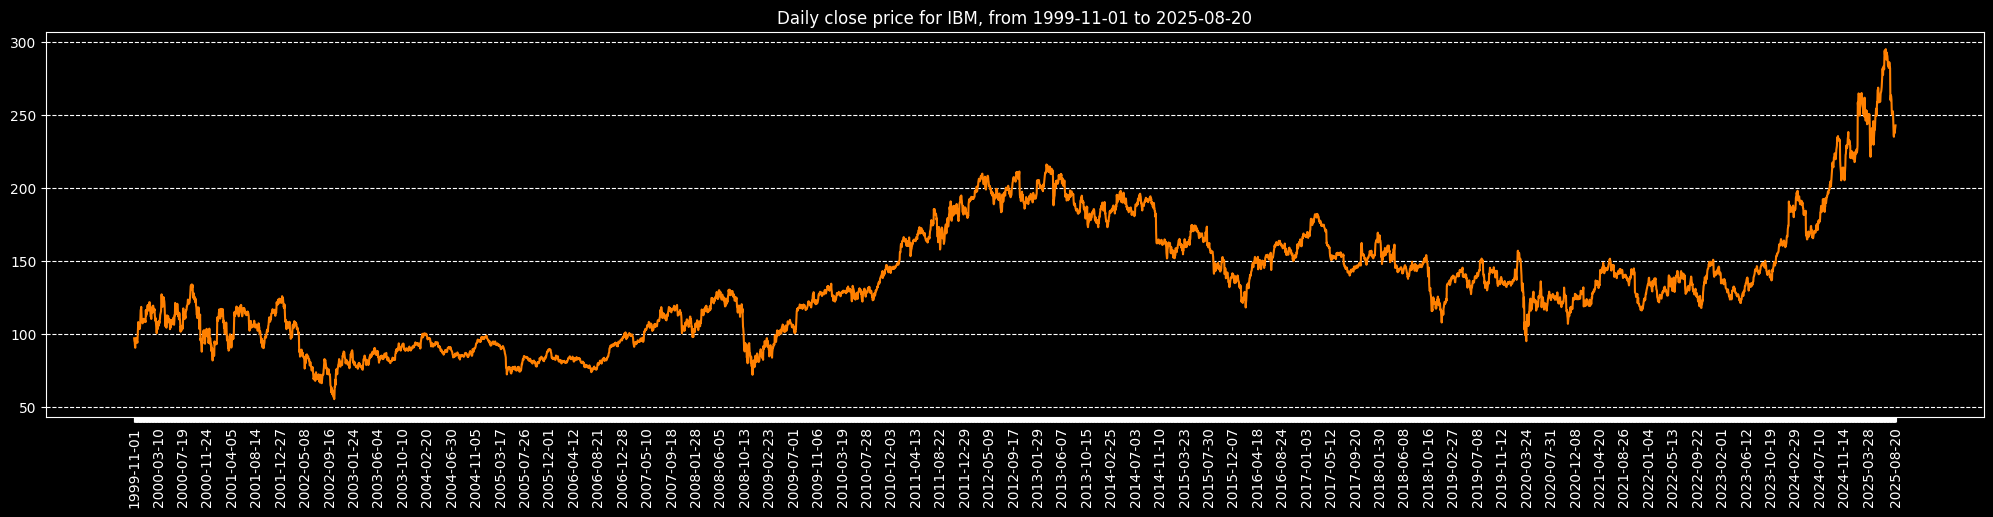

In [112]:
def plot_data(data_dates, data_close_price, num_data_points, display_date_range):
    fig = plt.figure(figsize=(25, 5), dpi=100)
    fig.patch.set_facecolor(color="black")
    plt.plot(data_dates, data_close_price, color=config["plots"]["color_actual"])

    xticks_labels = []
    xticks_interval = config["plots"]["xticks_interval"]

    for i in range(num_data_points):
        # Always include the last data point
        if i == num_data_points - 1:
            xticks_labels.append(data_dates[i])
        # Include every xticks_interval-th point, but avoid ticks too close to the end
        elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
            xticks_labels.append(data_dates[i])
        else:
            xticks_labels.append(None)

    xticks_indices = np.arange(0, len(xticks_labels))
    plt.xticks(xticks_indices, xticks_labels, rotation="vertical")

    plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range}")
    plt.grid(axis="y", linestyle="--")

plot_data(data_dates, data_close_price, num_data_points, display_date_range)

### Normalizing raw data

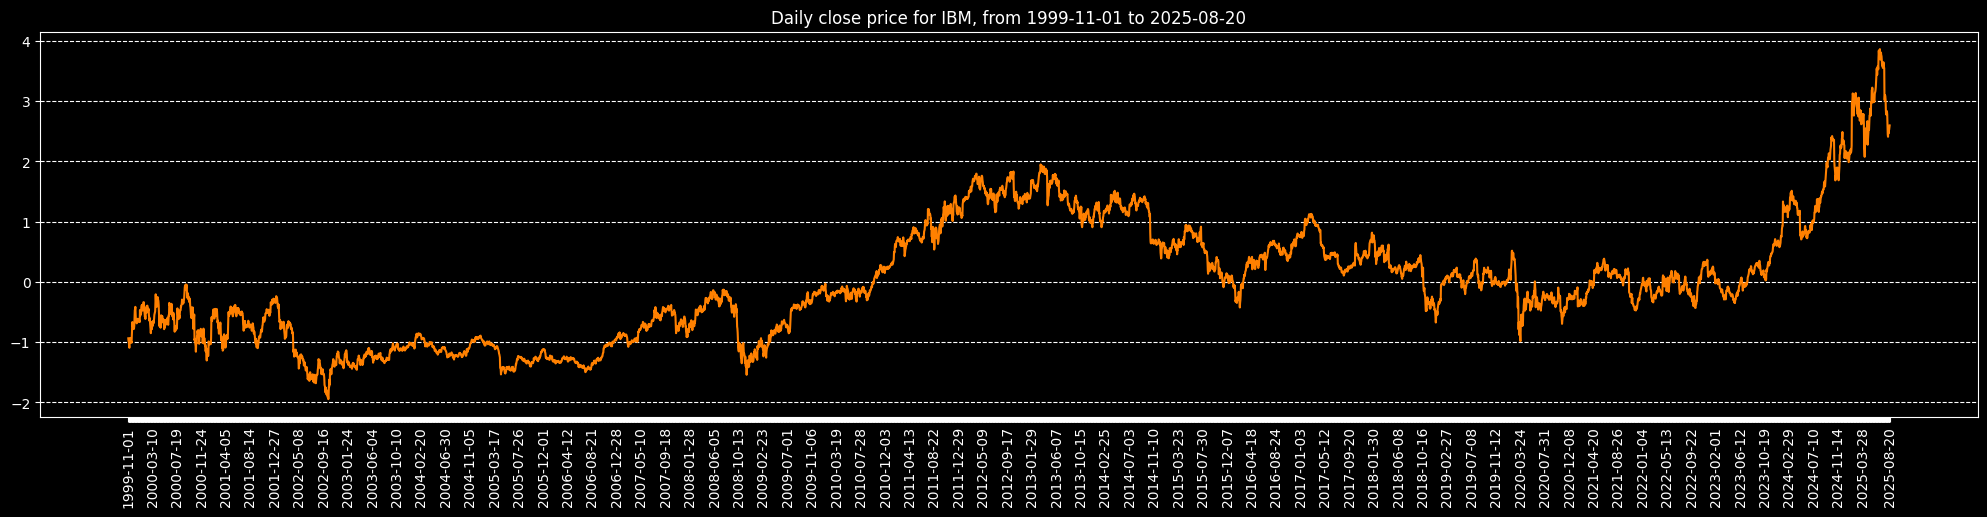

In [113]:
# use standardization
class Normalizer():
    def __init__(self):
        self.mean = None
        self.sd = None

    def standardize(self, data):
        self.mean = np.mean(data, axis=0, keepdims=True)
        self.std = np.std(data, axis=0, keepdims=True)
        return (data - self.mean) / self.std
    
    def inverse_transform(self, data):
        return data * self.std  + self.mean
    
scaler = Normalizer()
normalized_data_close_price = scaler.standardize(data_close_price)
plot_data(data_dates, normalized_data_close_price, num_data_points, display_date_range)

### Train/Val split

In [ ]:

def make_windows(data, window_size):
    n_row = data.shape[0] - window_size
    X = np.array([data[i:i+window_size] for i in range(n_row)])
    y = np.array([data[i+window_size] for i in range(n_row)])
    return X, y

X, y = make_windows(normalized_data_close_price, config["data"]["window_size"])

In [158]:
train_end = int(config["data"]["train_split_size"] * len(y))
val_end   = int((config["data"]["train_split_size"] + config["data"]["val_split_size"]) * len(y))

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(f"X_train: {X_train[:2]}\n ... \n{X_train[-2:]}. \ny_train {y_train[:2]} ... {y_train[-2:]}\n") 
print(f"X_val: {X_val[:2]}\n ... \n{X_val[-2:]}. \ny_val {y_val[:2]} ... {y_val[-2:]}\n") 
print(f"X_test: {X_test[:2]}\n ... \n{X_test[-2:]}. \ny_test {y_test[:2]} ... {y_test[-2:]}") 

(4529, 20) (4529,)
(970, 20) (970,)
(971, 20) (971,)
X_train: [[-0.93661436 -0.98363465 -0.99429904 -1.06240574 -1.09415655 -1.00472106
  -1.01247698 -0.93055505 -0.97902957 -0.95794315 -1.00181259 -0.98823972
  -1.00932614 -0.90631779 -0.76234847 -0.66709605 -0.71096548 -0.74877561
  -0.73665698 -0.75628916]
 [-0.98363465 -0.99429904 -1.06240574 -1.09415655 -1.00472106 -1.01247698
  -0.93055505 -0.97902957 -0.95794315 -1.00181259 -0.98823972 -1.00932614
  -0.90631779 -0.76234847 -0.66709605 -0.71096548 -0.74877561 -0.73665698
  -0.75628916 -0.78367726]]
 ... 
[[0.44321278 0.45969411 0.45242294 0.45169582 0.43521448 0.39231453
  0.37437896 0.38673996 0.39207216 0.36129084 0.33366037 0.31524005
  0.32711631 0.28373161 0.33269088 0.32905529 0.36638067 0.40128232
  0.39691961 0.39861622]
 [0.45969411 0.45242294 0.45169582 0.43521448 0.39231453 0.37437896
  0.38673996 0.39207216 0.36129084 0.33366037 0.31524005 0.32711631
  0.28373161 0.33269088 0.32905529 0.36638067 0.40128232 0.39691961


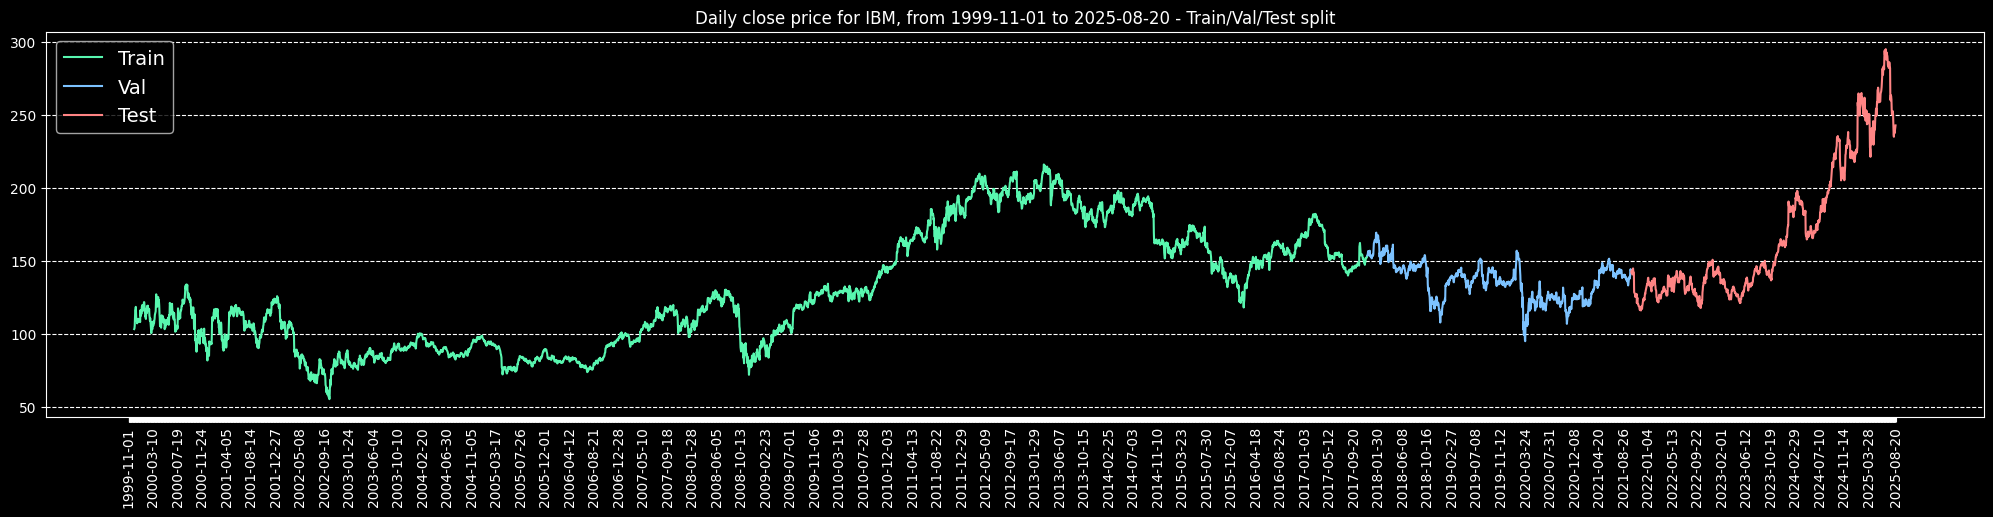

In [167]:
window_size = config["data"]["window_size"]

to_plot_data_y_train, to_plot_data_y_val, to_plot_data_y_test = np.array([None] * num_data_points), np.array([None] * num_data_points), np.array([None] * num_data_points)

to_plot_data_y_train[window_size : window_size + train_end] = scaler.inverse_transform(y_train)
to_plot_data_y_val[window_size + train_end : window_size + val_end] = scaler.inverse_transform(y_val)
to_plot_data_y_test[window_size + val_end : ] = scaler.inverse_transform(y_test)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])
plt.plot(data_dates, to_plot_data_y_test, label = "Test", color=config["plots"]["color_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]
for i in range(num_data_points):
    if i == num_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Train/Val/Test split")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Datasets and DataLoaders

In [161]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=-1) # (batch, sequence (window size)) -> (batch, sequence, features (1)). Only one feature (closing price)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
dataset_train = TimeSeriesDataset(X_train, y_train)
dataset_val = TimeSeriesDataset(X_val, y_val)
dataset_test = TimeSeriesDataset(X_test, y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

dataset_train.x[:2], dataset_train.y[0]

Train data shape torch.Size([4529, 20, 1]) torch.Size([4529])
Validation data shape torch.Size([970, 20, 1]) torch.Size([970])
Test data shape torch.Size([971, 20, 1]) torch.Size([971])


(tensor([[[-0.9366],
          [-0.9836],
          [-0.9943],
          [-1.0624],
          [-1.0942],
          [-1.0047],
          [-1.0125],
          [-0.9306],
          [-0.9790],
          [-0.9579],
          [-1.0018],
          [-0.9882],
          [-1.0093],
          [-0.9063],
          [-0.7623],
          [-0.6671],
          [-0.7110],
          [-0.7488],
          [-0.7367],
          [-0.7563]],
 
         [[-0.9836],
          [-0.9943],
          [-1.0624],
          [-1.0942],
          [-1.0047],
          [-1.0125],
          [-0.9306],
          [-0.9790],
          [-0.9579],
          [-1.0018],
          [-0.9882],
          [-1.0093],
          [-0.9063],
          [-0.7623],
          [-0.6671],
          [-0.7110],
          [-0.7488],
          [-0.7367],
          [-0.7563],
          [-0.7837]]]),
 tensor(-0.7837))

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=False)

## LSTM Model

$$
f_t = \sigma(W_{if} x_t + W_{hf} h_{t-1} + b_f) \\
i_t = \sigma(W_{ii} x_t + W_{hi} h_{t-1} + b_i) \\
\tilde{C}_t = \tanh(W_{iC} x_t + W_{hC} h_{t-1} + b_C) \\
o_t = \sigma(W_{io} x_t + W_{ho} h_{t-1} + b_o)
$$

In PyTorch, all the $W_{i*}$ (input -> gate) matrices are stacked together into weight_ih

All the $W_{h*}$ (hidden -> gate) are stacked together into weight_hh

$$
\begin{bmatrix}
f_t \\
i_t \\
\tilde{C}_t \\
o_t
\end{bmatrix}
=
\begin{bmatrix}
\sigma \\
\sigma \\
\tanh \\
\sigma
\end{bmatrix}
\Big(
W_{ih} x_t + W_{hh} h_{t-1} + b_{ih} + b_{hh}
\Big)
$$


In [169]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_layer_size)
        self.relu = nn.ReLU()
        # batch_first = True makes input/output (batch_size, seq_len, feature_num) instead of (seq_len, batch_size, feature_num) 
        self.lstm = nn.LSTM(input_size=hidden_layer_size,
                            hidden_size=hidden_layer_size,
                            num_layers=num_layers, 
                            batch_first=True,
                            dropout=dropout)

        self.dropout = nn.Dropout(p=dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if "bias" in name:
                 nn.init.zeros_(param)
            elif "weight_ih" in name:
                 nn.init.kaiming_normal_(param) # normal distribution scaled to preserve variance across layers
            elif "weight_hh" in name:
                 nn.init.orthogonal_(param) # preserves the gradient norm so it doesn't vanish/explode


    def forward(self, x):

        x = self.linear_1(x) # (batch, seq_len, num_features) -> (batch, seq_len, hidden_layer_size) 
        x = self.relu(x)

        # output has shape (batch, seq_len, hidden_layer_size). Hidden state from last LSTM layer, at every time step
        # h_n has shape (num_layers, batch, hidden_layer_size). Final hidden state for each layer, at the last time step
        # c_n has the same shape as h_n. Final cell state for each layer, at the last time step.
        output, (h_n, c_n) = self.lstm(x)

        x = h_n.transpose(0, 1).reshape(x.shape[0], -1) # (num_layers, batch, hidden_layer_size) -> (batch, num_layers*hidden_layer_size)

        x = self.dropout(x)

        x = self.linear_2(x) # (batch, output_size)
        return x.squeeze(-1)


## Model Training

In [170]:
model = LSTMModel(input_size=config["model"]["input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(params = model.parameters(),
                        lr=config["training"]["learning_rate"],
                        betas=(0.9, 0.98),
                        eps=1e-9)

scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=config["training"]["scheduler_step_size"],
                                      gamma=0.1)

device = config["training"]["device"]


best_val_loss = float('inf')
best_epoch = 0
model_path = f"best_model_{config["alpha_vantage"]["symbol"]}.pth"

for epoch in range(config["training"]["num_epoch"]):
    model.train()
    
    train_loss = 0.0

    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X) # (batch, 1) -> (batch,). Matches with y
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().item()

    train_loss = train_loss / len(train_dataloader)

    model.eval()

    val_loss = 0.0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)

            val_pred = model(X)
            val_loss += loss_fn(val_pred, y).item()


    val_loss = val_loss / len(val_dataloader)

    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)

    print(f"Epoch {epoch:03d}/{config["training"]["num_epoch"]} | train_loss: {train_loss:.6f} | val_loss: {val_loss:.6f} | lr: {current_lr:.6f}")

print(f"Best val loss: {best_val_loss} at epoch {best_epoch}")

Epoch 000/100 | train_loss: 0.042237 | val_loss: 0.003620 | lr: 0.010000
Epoch 001/100 | train_loss: 0.012329 | val_loss: 0.005113 | lr: 0.010000
Epoch 002/100 | train_loss: 0.010397 | val_loss: 0.003548 | lr: 0.010000
Epoch 003/100 | train_loss: 0.009413 | val_loss: 0.003607 | lr: 0.010000
Epoch 004/100 | train_loss: 0.010516 | val_loss: 0.003626 | lr: 0.010000
Epoch 005/100 | train_loss: 0.008912 | val_loss: 0.003996 | lr: 0.010000
Epoch 006/100 | train_loss: 0.009572 | val_loss: 0.003028 | lr: 0.010000
Epoch 007/100 | train_loss: 0.008013 | val_loss: 0.003257 | lr: 0.010000
Epoch 008/100 | train_loss: 0.008393 | val_loss: 0.003225 | lr: 0.010000
Epoch 009/100 | train_loss: 0.008003 | val_loss: 0.003045 | lr: 0.010000
Epoch 010/100 | train_loss: 0.008881 | val_loss: 0.004268 | lr: 0.010000
Epoch 011/100 | train_loss: 0.008305 | val_loss: 0.003673 | lr: 0.010000
Epoch 012/100 | train_loss: 0.008245 | val_loss: 0.003566 | lr: 0.010000
Epoch 013/100 | train_loss: 0.009090 | val_loss: 0.

## Model Evaluation

### Get Predictions

In [172]:
model.load_state_dict(torch.load(model_path))

train_preds_list = []
val_preds_list = []

train_eval_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False) # no shuffle

with torch.inference_mode():
    for X, y in train_eval_dataloader:
        X, y = X.to(device), y.to(device)

        train_pred = model(X)
        train_preds_list.append(train_pred)


    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)

        val_pred = model(X)
        val_preds_list.append(val_pred)

train_preds = torch.cat(train_preds_list).cpu().detach().numpy()
val_preds = torch.cat(val_preds_list).cpu().detach().numpy()

### Plot Predictions

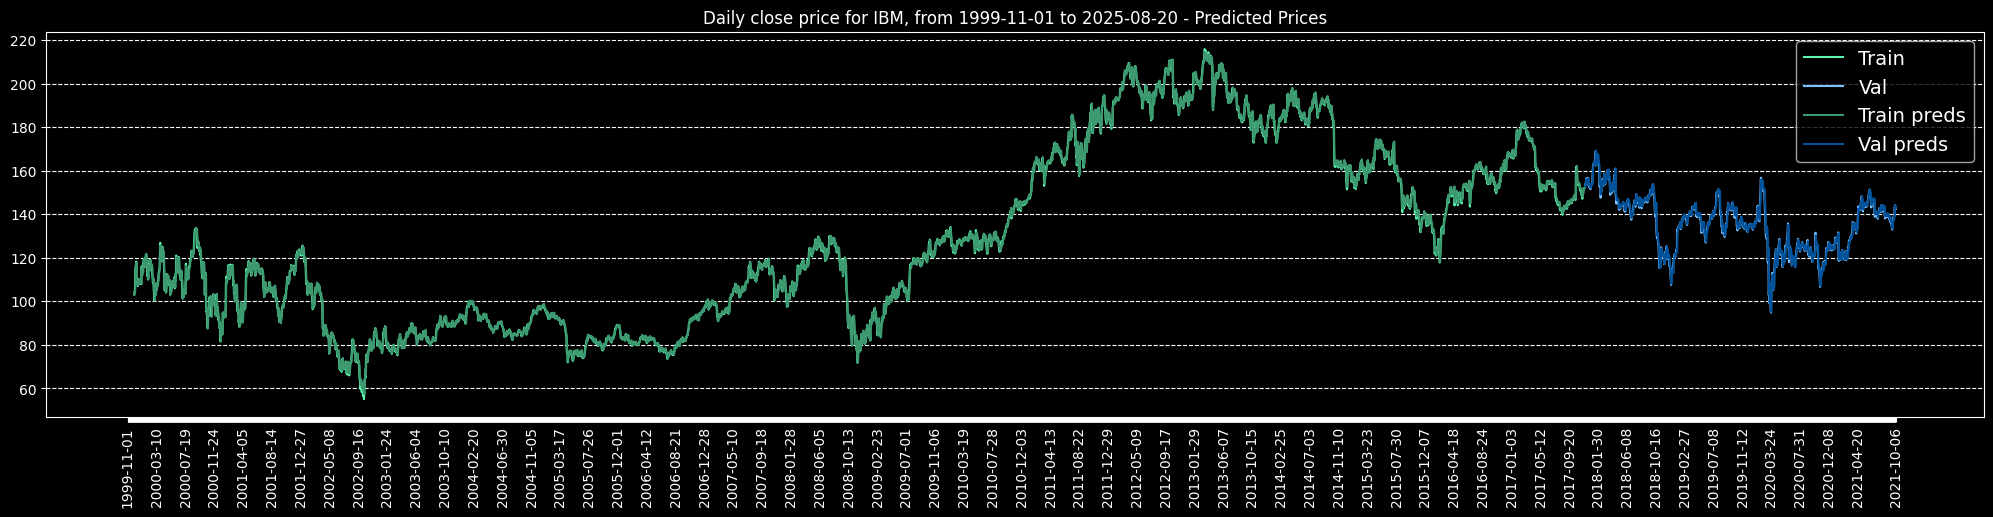

In [175]:
window_size = config["data"]["window_size"]


to_plot_y_train_preds = np.array([None] * num_data_points)
to_plot_y_val_preds = np.array([None] * num_data_points)

to_plot_y_train_preds[window_size : window_size + train_end] = scaler.inverse_transform(train_preds)
to_plot_y_val_preds[window_size + train_end : window_size + val_end] = scaler.inverse_transform(val_preds)


fig = plt.figure(figsize=(25, 5), dpi=100)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates, to_plot_data_y_train, label = "Train", color=config["plots"]["color_train"])
plt.plot(data_dates, to_plot_data_y_val, label = "Val", color=config["plots"]["color_val"])

plt.plot(data_dates, to_plot_y_train_preds, label = "Train preds", color=config["plots"]["color_pred_train"])
plt.plot(data_dates, to_plot_y_val_preds, label = "Val preds", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"]

num_pred_data_points = num_data_points - len(y_test)

for i in range(num_pred_data_points):
    if i == num_pred_data_points - 1:
        xticks_labels.append(data_dates[i])
    elif i % xticks_interval == 0 and (num_pred_data_points - i) > xticks_interval:
        xticks_labels.append(data_dates[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Daily close price for {config["alpha_vantage"]["symbol"]}, {display_date_range} - Predicted Prices")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Zoom in on Val Preds

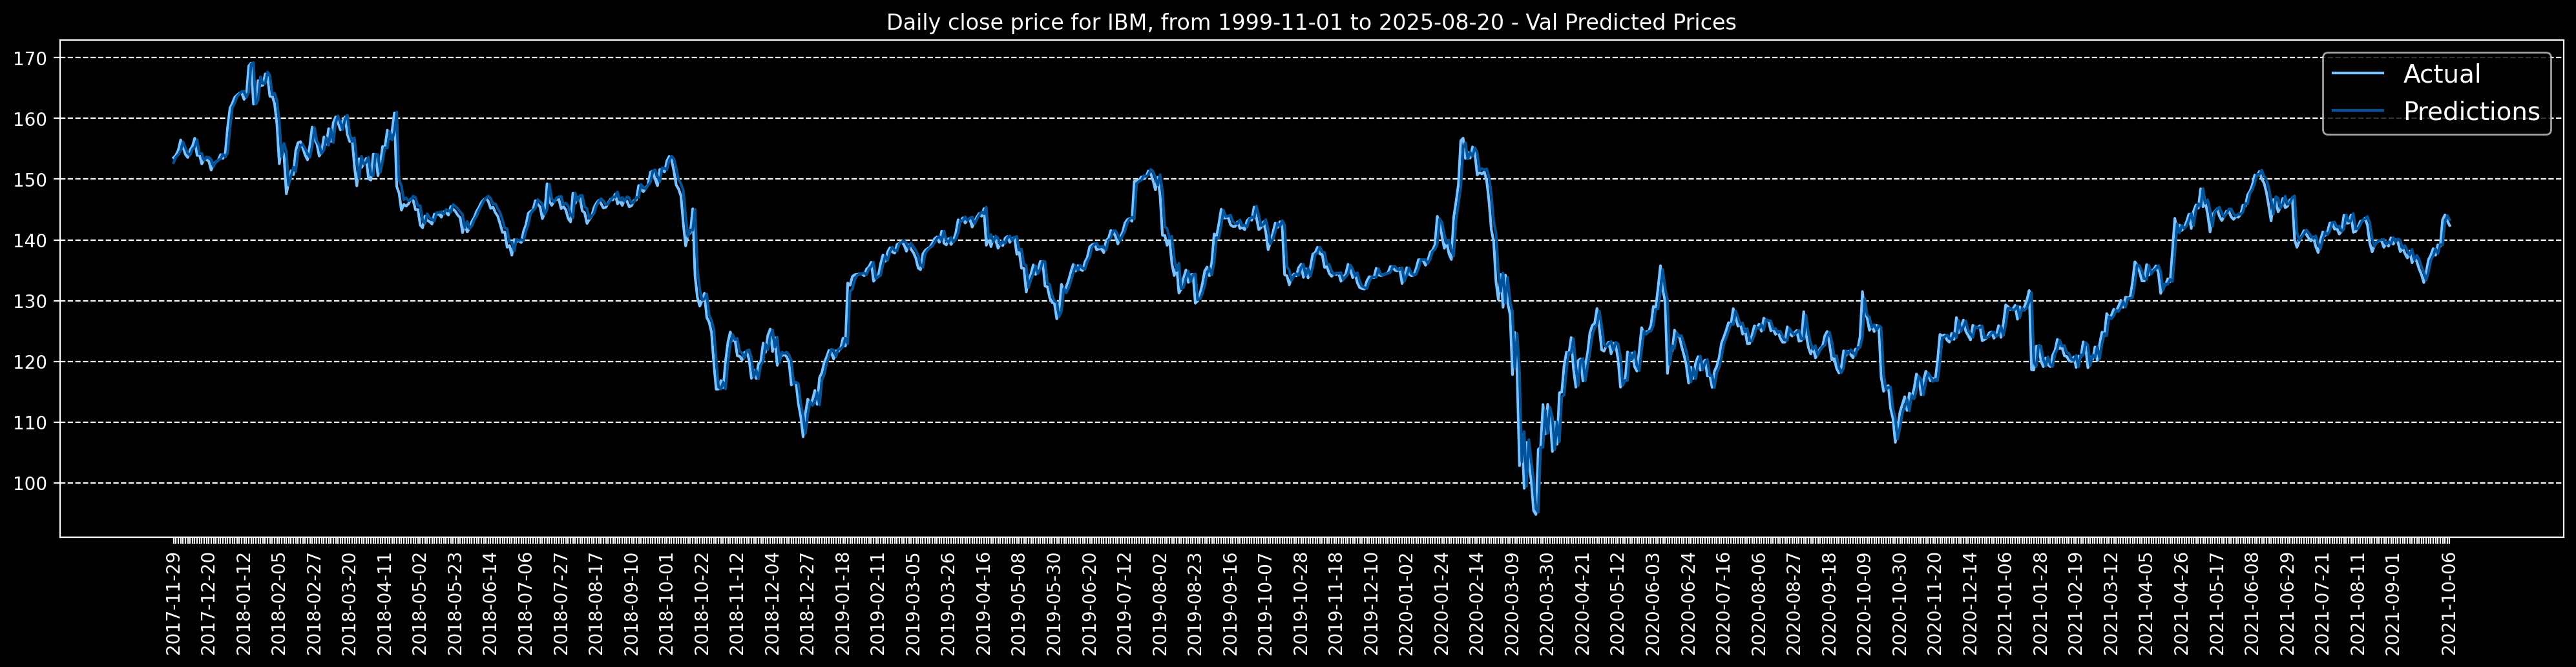

In [ ]:
y_val_preds = scaler.inverse_transform(val_preds)
y_val_only = scaler.inverse_transform(y_val)

data_dates_val = data_dates[window_size + train_end : window_size + val_end]

fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_val, y_val_only, label = "Actual", color=config["plots"]["color_val"])
plt.plot(data_dates_val, y_val_preds, label = "Predictions", color=config["plots"]["color_pred_val"])


xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_val_data_points = len(data_dates_val)

for i in range(num_val_data_points):
    if i == num_val_data_points - 1:
        xticks_labels.append(data_dates_val[i])
    elif i % (xticks_interval) == 0 and (num_val_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_val[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on val data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)


### Predictions on Test Data

In [220]:
X_test, y_test

(array([[0.05687087, 0.03942005, 0.06680815, ..., 0.21126221, 0.18799444,
         0.16884701],
        [0.03942005, 0.06680815, 0.02003024, ..., 0.18799444, 0.16884701,
         0.15551652],
        [0.06680815, 0.02003024, 0.04378275, ..., 0.16884701, 0.15551652,
         0.18969105],
        ...,
        [3.61902079, 3.55236833, 3.55358019, ..., 2.53706956, 2.46532727,
         2.52858652],
        [3.55236833, 3.55358019, 3.03247913, ..., 2.46532727, 2.52858652,
         2.52204246],
        [3.55358019, 3.03247913, 3.01333169, ..., 2.52858652, 2.52204246,
         2.56639664]], shape=(971, 20)),
 array([ 1.55516515e-01,  1.89691050e-01,  1.70543616e-01,  1.23038589e-01,
         1.30067394e-01,  1.93811384e-01,  2.23380840e-01,  1.67877517e-01,
         1.59636849e-01,  1.57697869e-01, -1.71201733e-01, -1.82108499e-01,
        -1.87925441e-01, -2.00286443e-01, -2.47791470e-01, -2.31552507e-01,
        -2.49488078e-01, -2.20888113e-01, -2.23311839e-01, -2.00286443e-01,
        -3.5

In [217]:
x = torch.tensor(X_test, dtype=torch.float).unsqueeze(-1)
x = x.to(config["training"]["device"])

model.eval()
with torch.inference_mode():
    test_preds = model(x)
    

test_preds = test_preds.cpu().detach().numpy()

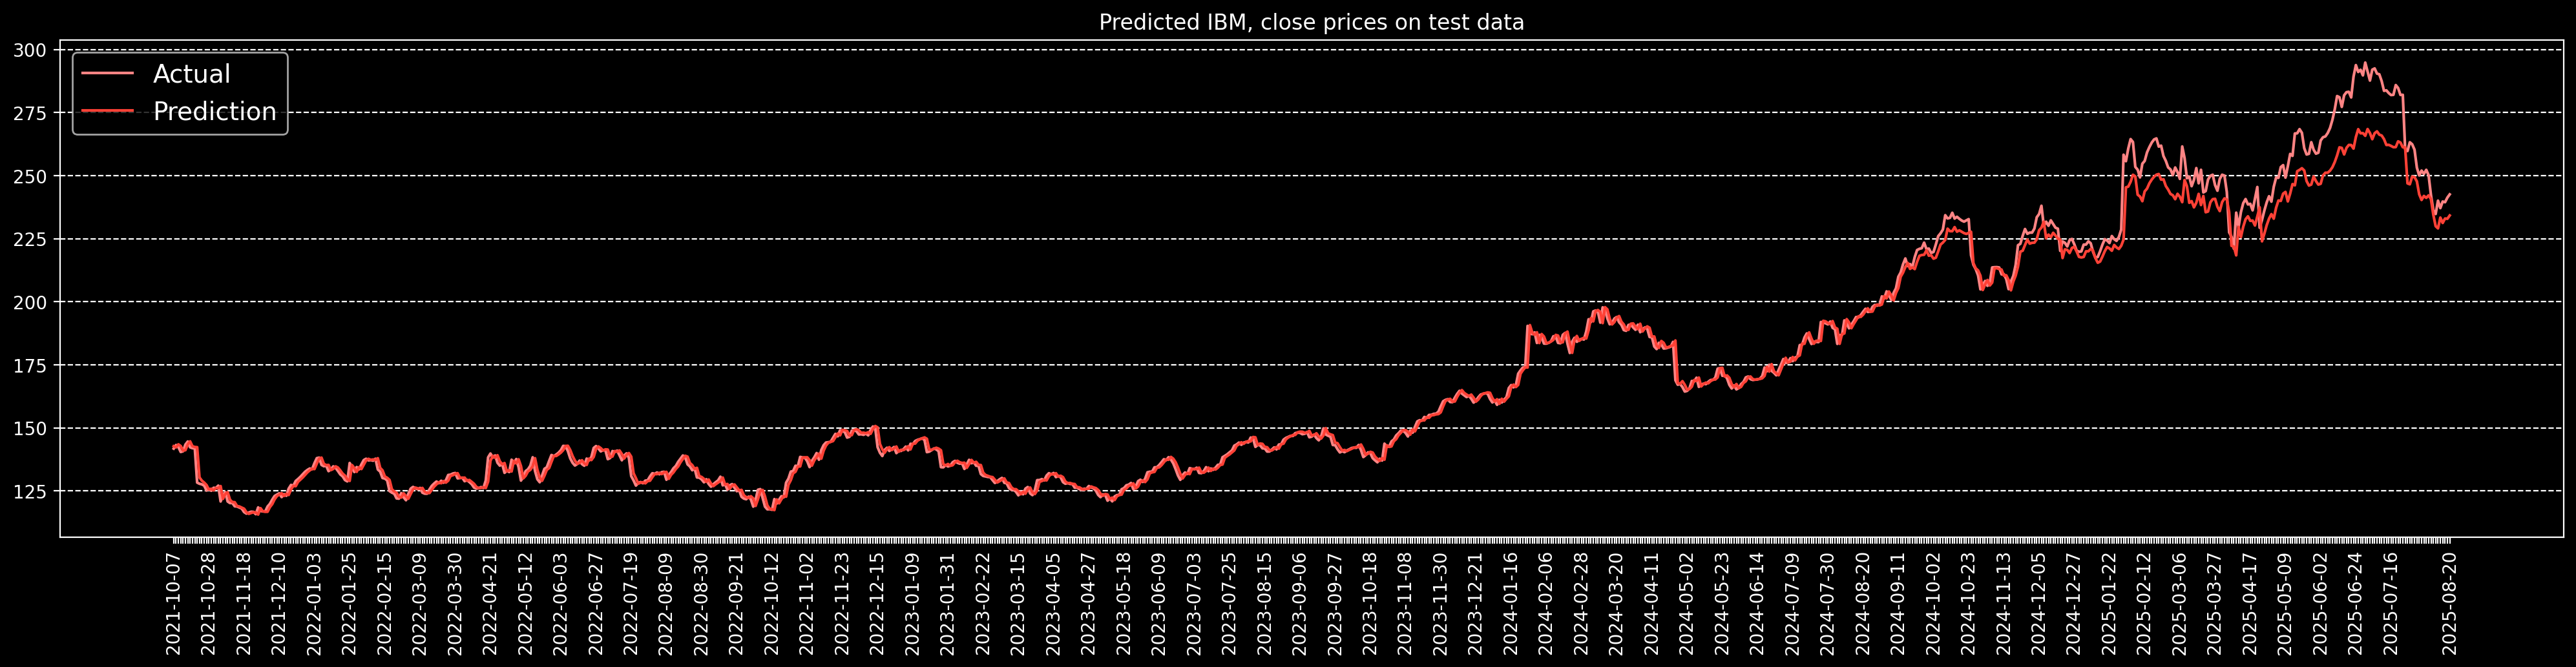

In [234]:
y_test_only = scaler.inverse_transform(y_test)
y_test_preds = scaler.inverse_transform(test_preds)

data_dates_test = data_dates[window_size + val_end:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test, y_test_only, label = "Actual", color=config["plots"]["color_test"])
plt.plot(data_dates_test, y_test_preds, label = "Prediction", color=config["plots"]["color_pred_test"])

xticks_labels = []
xticks_interval = config["plots"]["xticks_interval"] // 6

num_test_data_points = len(data_dates_test)

for i in range(num_test_data_points):
    if i == num_test_data_points - 1:
        xticks_labels.append(data_dates_test[i])
    elif i % (xticks_interval) == 0 and (num_test_data_points - i) > (xticks_interval):
        xticks_labels.append(data_dates_test[i])
    else:
        xticks_labels.append(None)
xticks_indices = np.arange(0, len(xticks_labels))

plt.xticks(xticks_indices, xticks_labels, rotation="vertical")
plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)

#### Zoom in

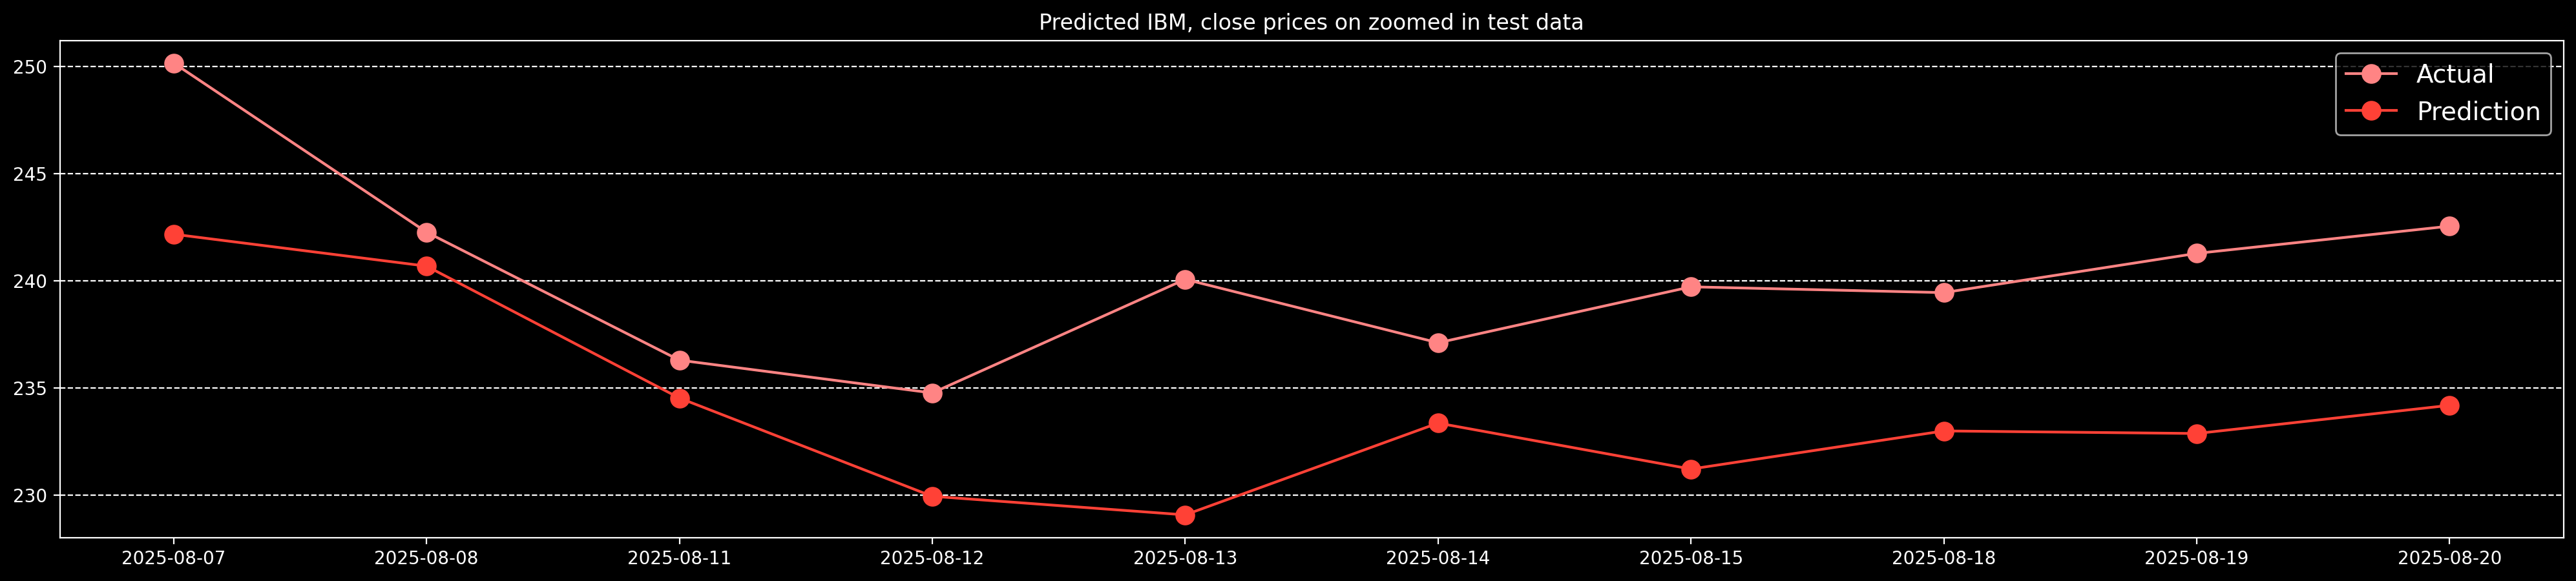

In [225]:
y_test_zoomed = y_test_only[-10:]
y_test_preds_zoomed = y_test_preds[-10:]

data_dates_test_zoomed = data_dates[-10:]


fig = plt.figure(figsize=(25, 5), dpi=200)
fig.patch.set_facecolor(color="black")

plt.plot(data_dates_test_zoomed, y_test_zoomed, label = "Actual", color=config["plots"]["color_test"], marker="o", markersize=10)
plt.plot(data_dates_test_zoomed, y_test_preds_zoomed, label = "Prediction", color=config["plots"]["color_pred_test"], marker="o", markersize=10)


plt.title(f"Predicted {config["alpha_vantage"]["symbol"]}, close prices on zoomed in test data")
plt.grid(axis="y", linestyle="--")
plt.legend(fontsize=14)